In [79]:
#https://builtin.com/data-science/time-series-forecasting-python

In [80]:
!pip install pandas-datareader -q
!pip install yfinance -q
!pip install seaborn -q
!pip install statsmodels -q

In [73]:
import pandas_datareader.data as web
import datetime
import pandas as pd 
import yfinance as yfin
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import mean_squared_error

yfin.pdr_override()
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [51]:
btc = web.get_data_yahoo(['BTC-USD'], start=datetime.datetime(2018, 1, 1), 
                         end=datetime.datetime(2020, 12, 2))[['Close']]
btc = btc.copy().rename(columns={'Close': 'BTC-USD'})
btc.head()

[*********************100%***********************]  1 of 1 completed


,BTC-USD
Date,
2018-01-01 00:00:00+00:00,13657.200195
2018-01-02 00:00:00+00:00,14982.099609
2018-01-03 00:00:00+00:00,15201.000000
2018-01-04 00:00:00+00:00,15599.200195
2018-01-05 00:00:00+00:00,17429.500000


In [52]:
sns.set()

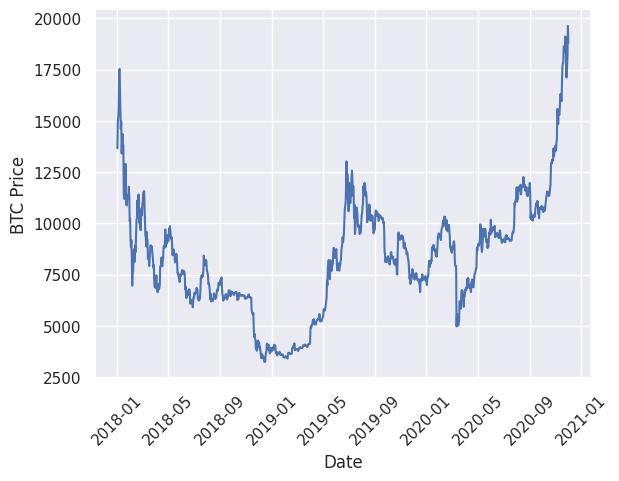

In [53]:
plt.ylabel('BTC Price')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.plot(btc.index, btc['BTC-USD'], )

In [54]:
btc.index = pd.to_datetime(btc.index, format='%Y-%m-%d')

In [55]:
train = btc[btc.index.date < pd.to_datetime("2020-11-01", format='%Y-%m-%d').date()]
test = btc[btc.index.date > pd.to_datetime("2020-11-01", format='%Y-%m-%d').date()]

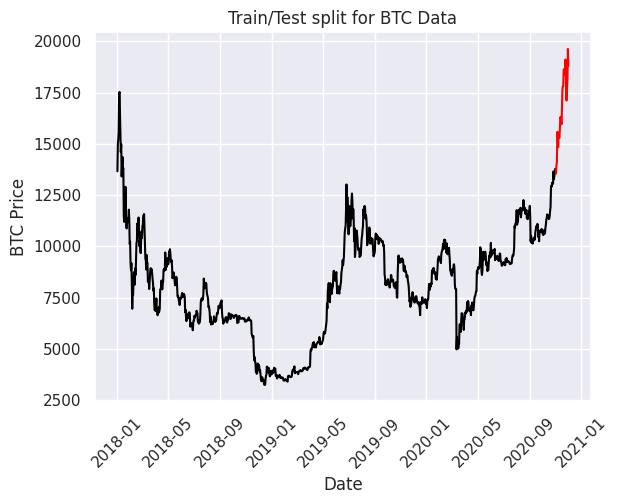

In [56]:
plt.plot(train, color = "black")
plt.plot(test, color = "red")
plt.ylabel('BTC Price')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.title("Train/Test split for BTC Data")
plt.show()

# Autoregressive Moving Average (ARMA)

In [78]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [58]:
y = train['BTC-USD']

In [76]:
ARMAmodel = SARIMAX(y, order = (1, 0, 1))
ARMAmodel = ARMAmodel.fit()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.25852D+00    |proj g|=  7.50049D-03

At iterate    5    f=  7.25849D+00    |proj g|=  2.46666D-03

At iterate   10    f=  7.25818D+00    |proj g|=  1.56769D-02

At iterate   15    f=  7.25789D+00    |proj g|=  2.90418D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     15     18      1     0     0   2.904D-05   7.258D+00
  F =   7.2578878303758634     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/home/jelena/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/jelena/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


In [ ]:
# Alpha corresponds to the significance level of our predictions. Typically, we choose an alpha = 0.05. 
# Here, the ARIMA algorithm calculates upper and lower bounds around the prediction such that there 
# is a 5 percent chance that the real value will be outside of the upper and lower bounds. 
# This means that there is a 95 percent confidence that the real value will be between the upper and 
# lower bounds of our predictions.

In [85]:
y_pred = ARMAmodel.get_forecast(len(test.index))
y_pred_df = y_pred.conf_int(alpha = 0.05) 
y_pred_df["Predictions"] = ARMAmodel.predict(start = y_pred_df.index[0], end = y_pred_df.index[-1])
y_pred_df.index = test.index
y_pred_arma = y_pred_df[["Predictions"]]

In [68]:
y_pred_df.head()

,lower BTC-USD,upper BTC-USD,Predictions
Date,,,
2020-11-02 00:00:00+00:00,13090.923541,14439.317026,13765.120283
2020-11-03 00:00:00+00:00,12824.222327,14693.585934,13758.904130
2020-11-04 00:00:00+00:00,12615.879245,14889.502324,13752.690785
2020-11-05 00:00:00+00:00,12438.553338,15054.407152,13746.480245
2020-11-06 00:00:00+00:00,12281.290888,15199.254130,13740.272509


In [86]:
y_pred_arma.head()

,Predictions
Date,
2020-11-02 00:00:00+00:00,13765.120283
2020-11-03 00:00:00+00:00,13758.904130
2020-11-04 00:00:00+00:00,13752.690785
2020-11-05 00:00:00+00:00,13746.480245
2020-11-06 00:00:00+00:00,13740.272509


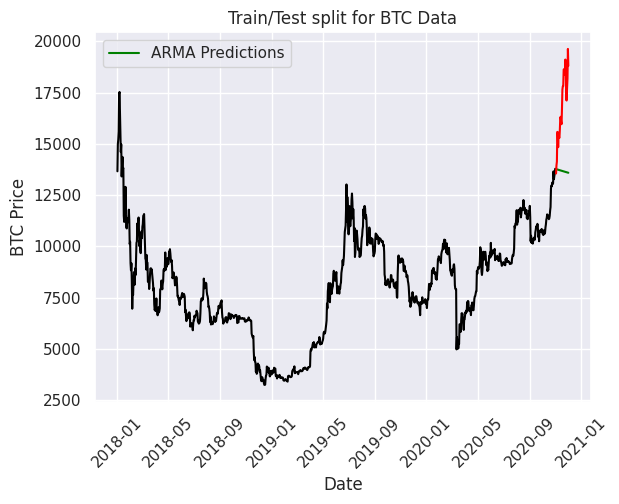

In [87]:
plt.plot(y_pred_arma, color='green', label = 'ARMA Predictions')
plt.plot(train, color = "black")
plt.plot(test, color = "red")
plt.ylabel('BTC Price')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.title("Train/Test split for BTC Data")
plt.legend()
plt.show()

In [88]:
arma_rmse = np.sqrt(mean_squared_error(test["BTC-USD"].values, y_pred_arma["Predictions"]))
print("RMSE: ", arma_rmse)

RMSE:  3562.135663852446


## ARMA is limited in that it fails for non-stationary time series and does not capture seasonality. 

# Autoregressive Integrated Moving Average (ARIMA)


In [77]:
from statsmodels.tsa.arima.model import ARIMA

In [95]:
# The first parameter corresponds to the lagging (past values), the second corresponds to differencing 
# (this is what makes non-stationary data stationary), and the last parameter corresponds to 
# the white noise (for modeling shock events). 

ARIMAmodel = ARIMA(y, order = (5, 4, 2))
ARIMAmodel = ARIMAmodel.fit()

y_pred = ARIMAmodel.get_forecast(len(test.index))
y_pred_df = y_pred.conf_int(alpha = 0.05) 
y_pred_df["Predictions"] = ARIMAmodel.predict(start = y_pred_df.index[0], end = y_pred_df.index[-1])
y_pred_df.index = test.index
y_pred_arima = y_pred_df[["Predictions"]]

/home/jelena/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/jelena/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/jelena/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/jelena/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


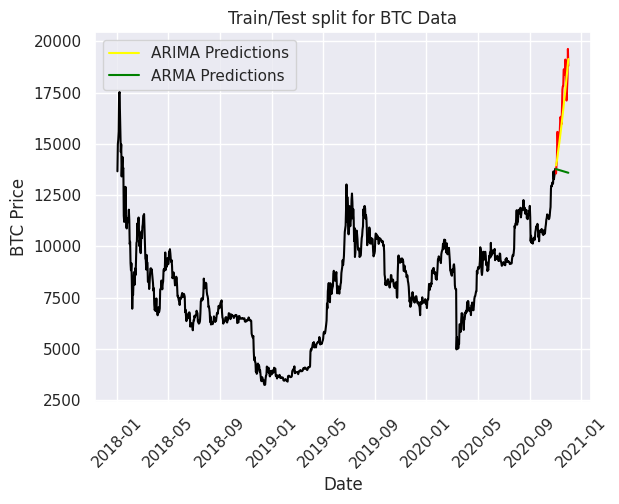

In [96]:
plt.plot(train, color = "black")
plt.plot(test, color = "red")
plt.ylabel('BTC Price')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.title("Train/Test split for BTC Data")
plt.plot(y_pred_arima, color='Yellow', label = 'ARIMA Predictions')
plt.plot(y_pred_arma, color='green', label = 'ARMA Predictions')
plt.legend()

In [99]:
arima_rmse = np.sqrt(mean_squared_error(test["BTC-USD"].values, y_pred_arima["Predictions"]))
print("RMSE: ", arima_rmse)

RMSE:  907.5828906567612


# SARIMA

## Seasonal ARIMA captures historical values, shock events and seasonality. 

In [100]:
SARIMAXmodel = SARIMAX(y, order = (5, 4, 2), seasonal_order=(2,2,2,12))
SARIMAXmodel = SARIMAXmodel.fit()

/home/jelena/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/jelena/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/jelena/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.22208D+00    |proj g|=  4.39254D-01


 This problem is unconstrained.



At iterate    5    f=  7.91299D+00    |proj g|=  1.99074D-02

At iterate   10    f=  7.90641D+00    |proj g|=  1.24235D-02

At iterate   15    f=  7.90241D+00    |proj g|=  4.76073D-03

At iterate   20    f=  7.89828D+00    |proj g|=  5.25738D-03

At iterate   25    f=  7.89703D+00    |proj g|=  3.29394D-03

At iterate   30    f=  7.89677D+00    |proj g|=  1.49440D-03

At iterate   35    f=  7.89409D+00    |proj g|=  2.29082D-02

At iterate   40    f=  7.88476D+00    |proj g|=  6.28360D-03

At iterate   45    f=  7.87500D+00    |proj g|=  1.66605D-02

At iterate   50    f=  7.87101D+00    |proj g|=  1.46234D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/home/jelena/.local/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


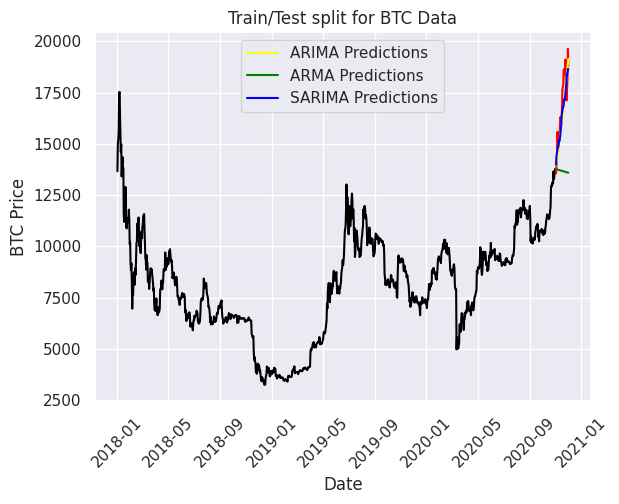

In [106]:
y_pred = SARIMAXmodel.get_forecast(len(test.index))
y_pred_df = y_pred.conf_int(alpha = 0.05) 
y_pred_df["Predictions"] = SARIMAXmodel.predict(start = y_pred_df.index[0], end = y_pred_df.index[-1])
y_pred_df.index = test.index
y_pred_sarima = y_pred_df[["Predictions"]]

plt.plot(train, color = "black")
plt.plot(test, color = "red")
plt.ylabel('BTC Price')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.title("Train/Test split for BTC Data")
plt.plot(y_pred_arima, color='Yellow', label = 'ARIMA Predictions')
plt.plot(y_pred_arma, color='green', label = 'ARMA Predictions')
plt.plot(y_pred_sarima, color='Blue', label = 'SARIMA Predictions')
plt.legend()

In [107]:
sarima_rmse = np.sqrt(mean_squared_error(test["BTC-USD"].values, y_pred_sarima["Predictions"]))
print("RMSE: ", sarima_rmse)

RMSE:  862.0806641337488
